# Handcrafted Features (Supervised Learning)

This notebook demonstrates the process of detecting OOD images by using handcrafted features such as RGB, HSL, entropy, and contrast to feed into a supervised learning model. This notebook contains code for training on `bollworms-train` and testing on `bollworms-test`.

# Imports

In [1]:
import os
import gc
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm
import tensorflow as tf
import tensorflow.keras.backend as K

# Navigate to to `OOD directory`

In [2]:
from google.colab import drive
drive.mount('/content/drive/', force_remount=True)

# Replace [OOD_DETECTION_REPOSITORY] with the correct location
os.chdir('/content/drive/[OOD_DETECTION_REPOSITORY]')
!git pull

Mounted at /content/drive/


### Build Training Dataset

In [4]:
from data_utils.datasets import find_image_files, build_dataset

dataset = 'bollworms' # [bollworms, bollworms-clean]

# These keyword arguments will be shared by all image datasets
ds_kwargs = {'cache': True, 'image_shape': (256, 256, 3), 'batch_size': 32, 'shuffle_buffer': 512}

if dataset == 'bollworms':
  # Build training sets of ID and OOD images for bollworms
  train_id_df = find_image_files('data/bollworms-train/ID')
  train_ood_df = find_image_files('data/bollworms-train/OOD')
  # Build testing sets of ID and OOD images for bollworms
  test_id_df = find_image_files('data/bollworms-test/ID')
  test_ood_df = find_image_files('data/bollworms-test/OOD')
else:
  # Build training sets of ID and OOD images for bollworms-clean
  train_id_df = find_image_files('data/bollworms-clean-train/ID')
  train_ood_df = find_image_files('data/bollworms-clean-train/OOD')
  # Build testing sets of ID and OOD images for bollworms-clean
  test_id_df = find_image_files('data/bollworms-clean-test/ID')
  test_ood_df = find_image_files('data/bollworms-clean-test/OOD')

train_id_ds = build_dataset(train_id_df, augment=False, shuffle=False, **ds_kwargs)
train_ood_ds = build_dataset(train_ood_df, augment=False, shuffle=False, **ds_kwargs)
test_id_ds = build_dataset(test_id_df, augment=False, shuffle=False, **ds_kwargs)
test_ood_ds = build_dataset(test_ood_df, augment=False, shuffle=False, **ds_kwargs)

# Build external test sets of Stanford Dogs
stanford_dogs_df = find_image_files('data/stanford_dogs/Images/*')
stanford_dogs_df = stanford_dogs_df.sample(frac=1, random_state=297) # Shuffle the data frame to get dogs of all types from top to bottom
stanford_dogs_ds = build_dataset(stanford_dogs_df.iloc[:3000,:], augment=False, shuffle=False, **ds_kwargs) # Use the first 3000 as a test

# Build external test sets of Oxford Flowers 102
flowers102_df = find_image_files('data/flowers102/*')
flowers102_df = flowers102_df.sample(frac=1, random_state=297) # Shuffle the data frame to get flowers of all types from top to bottom
flowers102_ds = build_dataset(flowers102_df.iloc[:3000,:], augment=False, shuffle=False, **ds_kwargs) # Use the first 3000 as a test

Found 7779 image files in folder "data/bollworms-train/ID"
Found 975 image files in folder "data/bollworms-train/OOD"
Found 865 image files in folder "data/bollworms-test/ID"
Found 108 image files in folder "data/bollworms-test/OOD"
Found 20580 image files in folder "data/stanford_dogs/Images/*"
Found 1620 image files in folder "data/flowers102/*"


# Generate handcrafted features

* We generate a series of handcrafted features based on data available in `bollworms-train`. 
* Features include the mean of each RGB channel, variance of each RGB channel, mean of HSL channels, variance of HSL channels, entropy (measure of 'surprise' or 'visual interest'), contrast, and the percent of pixels that are considered white-ish. 
* We selected a threshold of 0.90 by applying a mask to RGB to define the percent of pixels considered approximately white. This feature came from observing that many ID images were taken on blank white sheets of paper whereas OOD images were not. 
* We believe that this handcrafted feature can help us separate OOD from ID images. 
* Additionally, we scale the data to ensure each feature to ensure the flow of gradient descent is smooth, help our models quickly reach the minimum of loss function, and prevent our models from being biased towards a feature which happens to have to higher magnitude. 

**References:**
1. Understanding & Visualize Color Spaces to improve ML Models. Towards Data Science. [Source](https://towardsdatascience.com/understand-and-visualize-color-spaces-to-improve-your-machine-learning-and-deep-learning-models-4ece80108526). 




In [4]:
from models.supervised_feature_engineering import simple_model_generate_features, load_split_scale, plot_roc_curve, plot_det_curve, xgbmodel_metrics, return_metrics, logistic_regression_model_metrics
X_train, X_test, y_train, y_test, scaler_train = load_split_scale(train_id_ds, train_ood_ds, pct_whiteish_threshold=0.9)

Generating features for ood


100%|██████████| 31/31 [00:45<00:00,  1.48s/it]


Generating features for id


100%|██████████| 244/244 [03:38<00:00,  1.12it/s]


# Evaluating on train performance
* We apply Synthetic Minority Oversampling Technique (SMOTE) to handle class imbalance. [Source](https://arxiv.org/abs/1106.1813)
* This is because the cost of misclassifying an OOD (interesting) example as a normal example can be much higher than the cost of the reverse error. Under-sampling of the majority (normal) class has been proposed as a good means of increasing the sensitivity of a classifier to the minority class. 
* It has been show that SMOT features a combination of over-sampling the minority (abnormal) class and under-sampling the majority (normal) class that achieves better classifier performance than only under-sampling the majority class.

Logitic Regression with no SMOTE:
AUC: 0.966322527855991
F1: 0.8922673835113826
Accuracy ID: 0.9879142300194932
Accuracy OOD: 0.7407407407407407
Classification report:
                      precision    recall  f1-score   support

out-of-distribution       0.89      0.74      0.81       324
    in-distribution       0.97      0.99      0.98      2565

           accuracy                           0.96      2889
          macro avg       0.93      0.86      0.89      2889
       weighted avg       0.96      0.96      0.96      2889

Accuracy: 0.9601938386985116
Precision OOD: 0.9679144385026738
Recall OOD: 0.9879142300194932


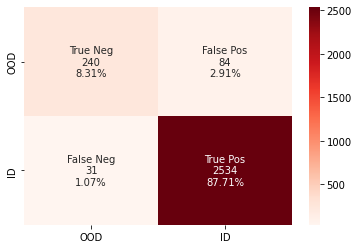

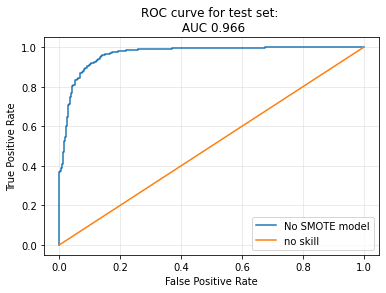

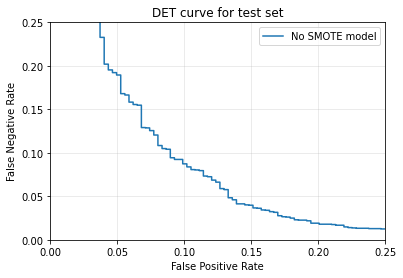

,features,weights,weights_abs
2,b_avg,2.061497,2.061497
8,g_b_corr,1.349791,1.349791
16,s_var,1.293129,1.293129
3,r_var,-1.184633,1.184633
6,r_g_corr,0.965602,0.965602
10,contrast,-0.755156,0.755156
5,b_var,0.686869,0.686869
11,pct_whiteish,-0.565441,0.565441
13,s_avg,-0.543785,0.543785
7,r_b_corr,-0.467954,0.467954


Logistic Regression + SMOTE:


/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


AUC: 0.9656763651240584
F1: 0.8395089161713238
Accuracy ID: 0.927485380116959
Accuracy OOD: 0.8919753086419753
Classification report:
                      precision    recall  f1-score   support

out-of-distribution       0.61      0.89      0.72       324
    in-distribution       0.99      0.93      0.96      2565

           accuracy                           0.92      2889
          macro avg       0.80      0.91      0.84      2889
       weighted avg       0.94      0.92      0.93      2889

Accuracy: 0.923502942194531
Precision OOD: 0.9855012427506213
Recall OOD: 0.927485380116959


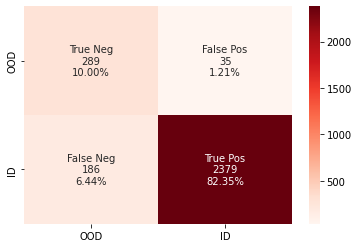

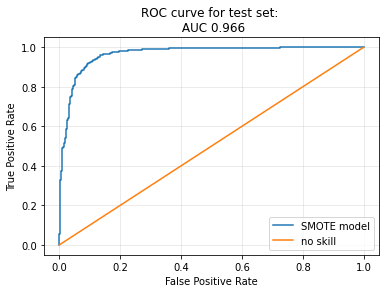

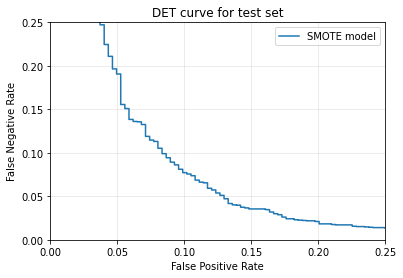

,features,weights,weights_abs
2,b_avg,2.766050,2.766050
16,s_var,2.737545,2.737545
6,r_g_corr,2.014744,2.014744
8,g_b_corr,1.974126,1.974126
3,r_var,-1.904087,1.904087
10,contrast,-1.747105,1.747105
7,r_b_corr,-1.058436,1.058436
13,s_avg,-1.015209,1.015209
5,b_var,0.759659,0.759659
1,g_avg,-0.590586,0.590586


XGBoost + SMOTE:
AUC: 0.9690076528770486
F1: 0.8567075017177035
Accuracy ID: 0.9403508771929825
Accuracy OOD: 0.8858024691358025
Classification report:
                      precision    recall  f1-score   support

out-of-distribution       0.65      0.89      0.75       324
    in-distribution       0.98      0.94      0.96      2565

           accuracy                           0.93      2889
          macro avg       0.82      0.91      0.86      2889
       weighted avg       0.95      0.93      0.94      2889

Accuracy: 0.9342332987192801
Precision OOD: 0.9848917925683952
Recall OOD: 0.9403508771929825


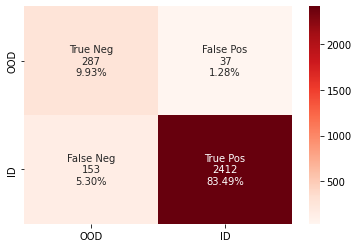

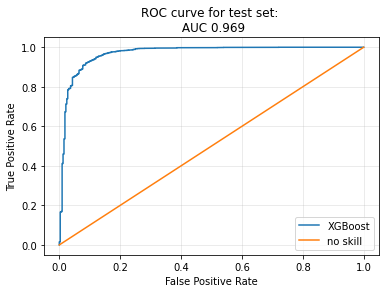

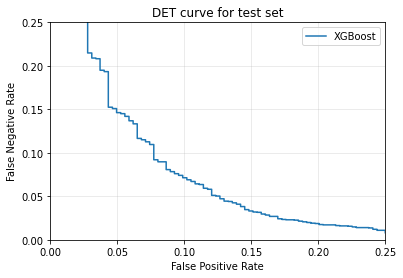

In [5]:
#logistic regression with no SMOTE
no_smote_model = logistic_regression_model_metrics(X_train, X_test, y_train, y_test,smote_flag=False)
#logistic regression with SMOTE
smote_model = logistic_regression_model_metrics(X_train, X_test, y_train, y_test,smote_flag=True)
#XGBoost with SMOTE 
xgb_model = xgbmodel_metrics(X_train, X_test, y_train, y_test)

# Testing on bollworms-test

100%|██████████| 28/28 [00:25<00:00,  1.10it/s]


AUC: 0.9514450867052022
F1: 0.8515938786923585
Accuracy ID: 0.9942196531791907
Accuracy OOD: 0.6018518518518519
Classification report:
                      precision    recall  f1-score   support

out-of-distribution       0.93      0.60      0.73       108
    in-distribution       0.95      0.99      0.97       865

           accuracy                           0.95       973
          macro avg       0.94      0.80      0.85       973
       weighted avg       0.95      0.95      0.95       973

Accuracy: 0.9506680369989723
Precision OOD: 0.9523809523809523
Recall OOD: 0.9942196531791907


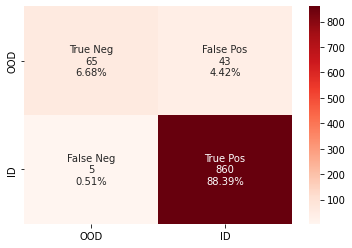

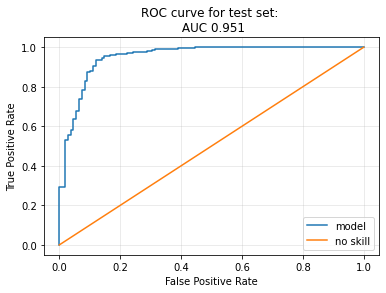

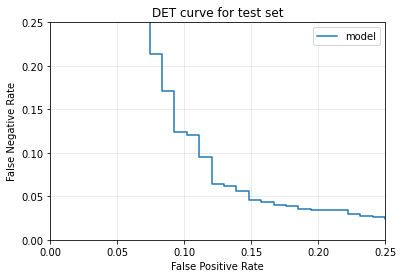

,features,weights,weights_abs
2,b_avg,2.061497,2.061497
8,g_b_corr,1.349791,1.349791
16,s_var,1.293129,1.293129
3,r_var,-1.184633,1.184633
6,r_g_corr,0.965602,0.965602
10,contrast,-0.755156,0.755156
5,b_var,0.686869,0.686869
11,pct_whiteish,-0.565441,0.565441
13,s_avg,-0.543785,0.543785
7,r_b_corr,-0.467954,0.467954


In [6]:
x_test_ood, y_test_ood = simple_model_generate_features(test_ood_ds,ood=True,pct_whiteish_threshold=0.9)
x_test_id, y_test_id = simple_model_generate_features(test_id_ds,ood=False,pct_whiteish_threshold=0.9)
x_test_ood_scaled = scaler_train.transform(x_test_ood)
x_test_id_scaled = scaler_train.transform(x_test_id)
holdout_x= np.vstack((x_test_id_scaled,x_test_ood_scaled))
holdout_y= np.vstack((y_test_id.reshape(-1,1),y_test_ood.reshape(-1,1)))
return_metrics(no_smote_model,holdout_x,holdout_y)

AUC: 0.9622564761293084
F1: 0.8384915356367316
Accuracy ID: 0.9317919075144508
Accuracy OOD: 0.8703703703703703
Classification report:
                      precision    recall  f1-score   support

out-of-distribution       0.61      0.87      0.72       108
    in-distribution       0.98      0.93      0.96       865

           accuracy                           0.92       973
          macro avg       0.80      0.90      0.84       973
       weighted avg       0.94      0.92      0.93       973

Accuracy: 0.9249743062692704
Precision OOD: 0.9829268292682927
Recall OOD: 0.9317919075144508


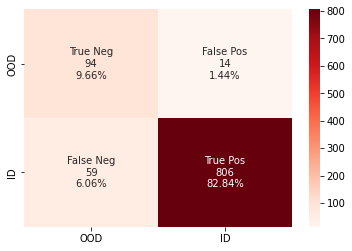

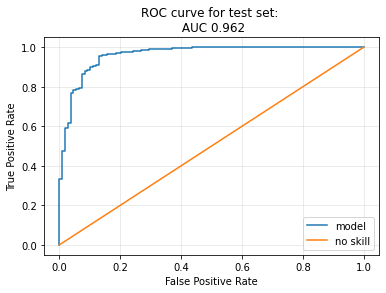

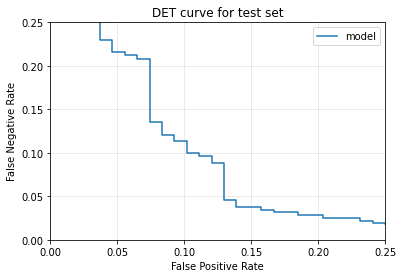

,features,weights,weights_abs
2,b_avg,2.766050,2.766050
16,s_var,2.737545,2.737545
6,r_g_corr,2.014744,2.014744
8,g_b_corr,1.974126,1.974126
3,r_var,-1.904087,1.904087
10,contrast,-1.747105,1.747105
7,r_b_corr,-1.058436,1.058436
13,s_avg,-1.015209,1.015209
5,b_var,0.759659,0.759659
1,g_avg,-0.590586,0.590586


In [7]:
return_metrics(smote_model,holdout_x,holdout_y)

AUC: 0.9660779276386212
F1: 0.8563851770216282
Accuracy ID: 0.9526011560693641
Accuracy OOD: 0.8240740740740741
Classification report:
                      precision    recall  f1-score   support

out-of-distribution       0.68      0.82      0.75       108
    in-distribution       0.98      0.95      0.96       865

           accuracy                           0.94       973
          macro avg       0.83      0.89      0.86       973
       weighted avg       0.94      0.94      0.94       973

Accuracy: 0.9383350462487153
Precision OOD: 0.9774614472123369
Recall OOD: 0.9526011560693641


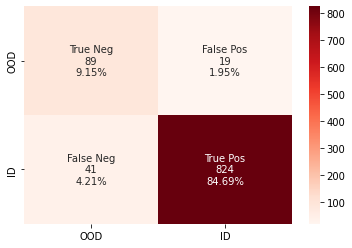

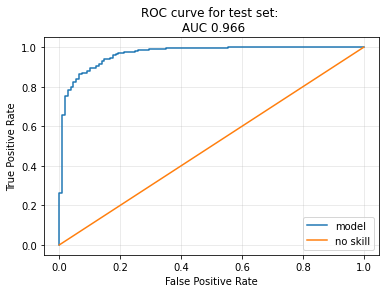

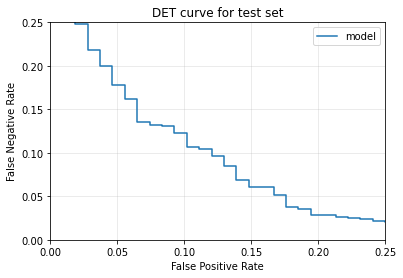

In [8]:
return_metrics(xgb_model,holdout_x,holdout_y)

# Visualize ID probability and threshold to maximize F1

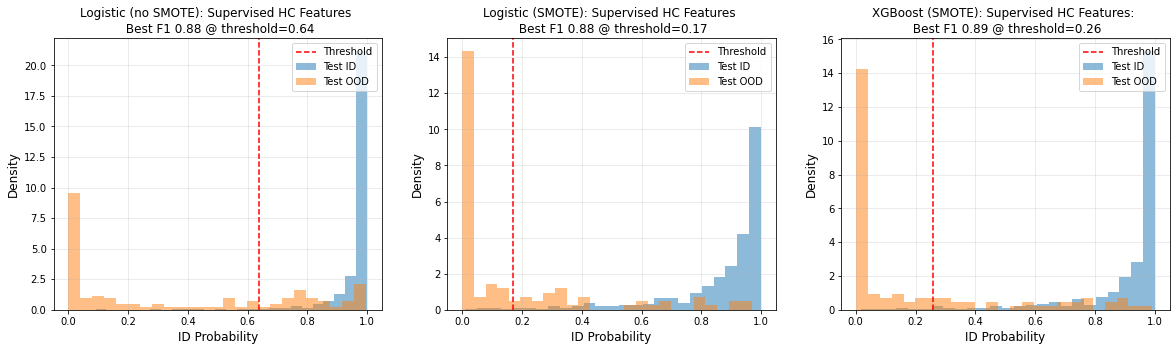

In [9]:
from analysis.classifiers import get_auroc, get_f1_maximizing_threshold, get_classification_report

fig, (ax1, ax2,ax3) = plt.subplots(1, 3, figsize=(20, 5))
scores_train_id = no_smote_model.predict_proba(x_test_id_scaled)[:,1]
scores_train_ood = no_smote_model.predict_proba(x_test_ood_scaled)[:,1]
threshold, max_f1_score = get_f1_maximizing_threshold(scores_train_id, scores_train_ood)
ax1.hist(scores_train_id,label='Test ID', bins=25, alpha=0.5, density=True);
ax1.hist(scores_train_ood,label='Test OOD', bins=25, alpha=0.5, density=True);
ax1.set_xlabel('ID Probability', fontsize=12)
ax1.set_ylabel('Density', fontsize=12)
ax1.set_title(f'Logistic (no SMOTE): Supervised HC Features \n Best F1 {max_f1_score:.2f} @ threshold={threshold:.2f}')
ax1.axvline(threshold, color='r', linestyle='--', label='Threshold')
ax1.legend(loc='upper right')
ax1.grid(alpha=0.3)

scores_train_id = smote_model.predict_proba(x_test_id_scaled)[:,1]
scores_train_ood = smote_model.predict_proba(x_test_ood_scaled)[:,1]
threshold, max_f1_score = get_f1_maximizing_threshold(scores_train_id, scores_train_ood)
ax2.hist(scores_train_id,label='Test ID', bins=25, alpha=0.5, density=True);
ax2.hist(scores_train_ood,label='Test OOD', bins=25, alpha=0.5, density=True);
ax2.set_xlabel('ID Probability', fontsize=12)
ax2.set_ylabel('Density', fontsize=12)
ax2.set_title(f'Logistic (SMOTE): Supervised HC Features \n Best F1 {max_f1_score:.2f} @ threshold={threshold:.2f}')
ax2.axvline(threshold, color='r', linestyle='--', label='Threshold')
ax2.legend(loc='upper right')
ax2.grid(alpha=0.3)

scores_train_id = xgb_model.predict_proba(x_test_id_scaled)[:,1]
scores_train_ood = xgb_model.predict_proba(x_test_ood_scaled)[:,1]
threshold, max_f1_score = get_f1_maximizing_threshold(scores_train_id, scores_train_ood)
ax3.hist(scores_train_id,label='Test ID', bins=25, alpha=0.5, density=True);
ax3.hist(scores_train_ood,label='Test OOD', bins=25, alpha=0.5, density=True);
ax3.set_xlabel('ID Probability', fontsize=12)
ax3.set_ylabel('Density', fontsize=12)
ax3.set_title(f'XGBoost (SMOTE): Supervised HC Features: \n Best F1 {max_f1_score:.2f} @ threshold={threshold:.2f}')
ax3.axvline(threshold, color='r', linestyle='--', label='Threshold')
ax3.legend(loc='upper right')
ax3.grid(alpha=0.3)

* XGBoost with SMOTE performs the best, returning an F1 score of 0.89.

# Evaluation metrics for best model (XGboost) with threshold that maximizes F1

In [10]:
scores_test_id = xgb_model.predict_proba(x_test_id_scaled)[:,1]
scores_test_ood = xgb_model.predict_proba(x_test_ood_scaled)[:,1]
best_threshold, max_f1_score = get_f1_maximizing_threshold(scores_train_id, scores_train_ood)

# Compute and report all classifier metrics of interest 
auc = get_auroc(scores_test_id, scores_test_ood)
class_report, conf_matrix = get_classification_report(scores_test_id, scores_test_ood, best_threshold)
per_class_accuracy = conf_matrix.diagonal()/conf_matrix.sum(axis=1)
tn, fp, fn, tp = conf_matrix.ravel()

print(f'Classification report on test set:')
print('')
print(class_report)
print(f'OOD accuracy: {per_class_accuracy[0]:.3f}')
print(f' ID accuracy: {per_class_accuracy[1]:.3f}')
print('')
print('Breakdown:', {'TN': tn, 'FP': fp, 'FN': fn, 'TP': tp})
print('')
print(f'AUC: {auc:.3f}')
print('')

Classification report on test set:

              precision    recall  f1-score   support

      OOD: 0      0.860     0.741     0.796       108
       ID: 1      0.968     0.985     0.977       865

    accuracy                          0.958       973
   macro avg      0.914     0.863     0.886       973
weighted avg      0.956     0.958     0.956       973

OOD accuracy: 0.741
 ID accuracy: 0.985

Breakdown: {'TN': 80, 'FP': 28, 'FN': 13, 'TP': 852}

AUC: 0.966



### Results in technical report
* AUROC: 0.966
* Macro-F1:  0.886
* Acc. (ID): 0.985
* Acc. (OOD): 0.741


# External datasets

In [68]:
from sklearn.metrics import accuracy_score
x_test_flowers, y_test_flowers = simple_model_generate_features(flowers102_ds,ood=True,pct_whiteish_threshold=0.9)
x_test_flowers_scaled = scaler_train.transform(x_test_flowers)
flowers_preds = xgb_model.predict(x_test_flowers_scaled)
print("============")
print("Accuracy score for Oxford flowers:",accuracy_score(flowers_preds,y_test_flowers.reshape(-1,1)))

100%|██████████| 51/51 [00:48<00:00,  1.04it/s]

Accuracy score for Oxford flowers: 0.9820987654320987


In [70]:
x_test_dog, y_test_dog = simple_model_generate_features(stanford_dogs_ds,ood=True,pct_whiteish_threshold=0.9)
x_test_dog_scaled = scaler_train.transform(x_test_dog)
dog_preds = xgb_model.predict(x_test_dog_scaled)
print("============")
print("Accuracy score for Stanford dogs:",accuracy_score(dog_preds,y_test_dog.reshape(-1,1)))

100%|██████████| 94/94 [01:33<00:00,  1.01it/s]

Accuracy score for Stanford dogs: 0.939
